# 🧠 BRISC Binary Classification: Model Evaluation
This notebook evaluates multiple pre-trained ResNet-18 models on the BRISC 2025 classification dataset. 

## 1. Setup and Environment
Mount Google Drive to access saved model weights and fetch the dataset from Kaggle.

In [60]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [61]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brisc2025' dataset.
Path to dataset files: /kaggle/input/brisc2025


In [62]:
!find /kaggle/input/brisc2025 -maxdepth 3

/kaggle/input/brisc2025
/kaggle/input/brisc2025/brisc2025
/kaggle/input/brisc2025/brisc2025/manifest.json
/kaggle/input/brisc2025/brisc2025/README.md
/kaggle/input/brisc2025/brisc2025/segmentation_task
/kaggle/input/brisc2025/brisc2025/segmentation_task/test
/kaggle/input/brisc2025/brisc2025/segmentation_task/train
/kaggle/input/brisc2025/brisc2025/classification_task
/kaggle/input/brisc2025/brisc2025/classification_task/test
/kaggle/input/brisc2025/brisc2025/classification_task/train
/kaggle/input/brisc2025/brisc2025/manifest.csv
/kaggle/input/brisc2025/brisc2025/manifest.json.sha256
/kaggle/input/brisc2025/brisc2025/manifest.csv.sha256


In [63]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [64]:
!find /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing -maxdepth 1

/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing
/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing/notumor
/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing/meningioma
/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing/glioma
/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing/pituitary


In [65]:
BRICS_TEST_DIR = '/kaggle/input/brisc2025/brisc2025/classification_task/test'
FIG_SHARE_TEST_DIR = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Testing'
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001
input_size = 224 
reshape_size =256

## 2. Imports and Configuration
Load all necessary libraries and set the global hyperparameters and directory paths.

In [66]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

from torch.utils.data import DataLoader


## 3. Data Loading and Preprocessing
Define the image transformations and initialize the test DataLoader.

In [67]:
# Define how to process the images


transform = transforms.Compose([
    transforms.Resize((reshape_size, reshape_size)),
    transforms.RandomHorizontalFlip(p=0.5), # Flips 50% of images like a mirror
    transforms.RandomRotation(degrees=15 ),
    transforms.CenterCrop((input_size, input_size)),  # Tilts the brain up to 15 degrees
    
    transforms.ToTensor(),
])
binary_transform = lambda target: 0 if target == 2 else 1

brics_test_dataset = datasets.ImageFolder(
    root=BRICS_TEST_DIR,
    transform=transform,
    target_transform=binary_transform
)

figshare_test_dataset = datasets.ImageFolder(
    root=FIG_SHARE_TEST_DIR,
    transform=transform,
    target_transform=binary_transform
)

# shuffle=False is important here so we can match predictions to the right labels
brics_test_loader = DataLoader(brics_test_dataset, batch_size=32, shuffle=False)

figshare_test_loader = DataLoader(figshare_test_dataset, batch_size=32, shuffle=False)

test_loaders = {
    "BRISC": brics_test_loader, 
    "Figshare": figshare_test_loader
}

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4. Helper Functions
Define reusable functions for loading models and evaluating their performance.

In [77]:
def load_resnet_model(weight_path, device):
    """Builds the ResNet-18 skeleton and loads custom weights."""
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    return model.to(device)


def evaluate_model_multidataset(model, test_loaders, device, threshold=0.3, model_name="Model"):
    """
    Evaluates a PyTorch binary classification model on multiple datasets 
    and plots Confusion Matrices side-by-side in a 1x2 grid.
    
    Args:
        model: The PyTorch model to evaluate.
        test_loaders: A dictionary of DataLoaders {'Dataset1': loader1, 'Dataset2': loader2}.
        device: The device to run on (e.g., 'cuda' or 'cpu').
        threshold: The probability threshold for positive classification (default: 0.3).
        model_name: String name of the model for titles and print statements.
    """
    print(f"\nEvaluating {model_name} on multiple datasets...")
    model.eval() 
    
    # Set up the 1x2 subplot grid (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{model_name} - Confusion Matrices', fontsize=16, y=1.05)
    
    # Store metrics to return later if needed
    results = {}

    with torch.no_grad(): 
        # Loop through each dataset
        for idx, (dataset_name, loader) in enumerate(test_loaders.items()):
            print(f"\nProcessing {dataset_name} Dataset...")
            all_preds, all_labels, all_probs = [], [], []
            
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device).float()

                outputs = model(images).squeeze()
                
                # Safety check for batch size of 1
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                    
                probs = torch.sigmoid(outputs)    
                preds = (probs >= threshold).float()    

                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            # Calculate Core Metrics
            accuracy = accuracy_score(all_labels, all_preds)
            sensitivity = recall_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds)
            auc = roc_auc_score(all_labels, all_probs)
            
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            specificity = tn / (tn + fp)

            print(f"--- {dataset_name} Results ---")
            print(f"Accuracy:    {accuracy * 100:.2f}% | Sensitivity: {sensitivity * 100:.2f}%")
            print(f"Specificity: {specificity * 100:.2f}% | F1-Score:    {f1:.4f} | AUC: {auc:.4f}")

            results[dataset_name] = {
                "Accuracy": accuracy, 
                "Sensitivity": sensitivity, 
                "Specificity": specificity, 
                "F1": f1, 
                "AUC": auc
            }

            # --- Plot: Confusion Matrix ---
            cm = confusion_matrix(all_labels, all_preds)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['No Tumor', 'Tumor'],
                        yticklabels=['No Tumor', 'Tumor'],
                        annot_kws={"size": 14}, 
                        ax=axes[idx]) # Maps to axes[0] then axes[1]
            
            axes[idx].set_ylabel('Actual Diagnosis', fontsize=12)
            axes[idx].set_xlabel('Model Prediction', fontsize=12)
            axes[idx].set_title(f'{dataset_name}', fontsize=14, pad=10)

    plt.tight_layout() 
    plt.show() 
    
    return results

## 5. Model Inference & Comparison
Load each saved model and pass it through the evaluation pipeline.

In [70]:
!find /content/drive/MyDrive/my_models

/content/drive/MyDrive/my_models
/content/drive/MyDrive/my_models/binary_brain_tumor_detector.h5
/content/drive/MyDrive/my_models/binary_brain_tumor_detector.keras
/content/drive/MyDrive/my_models/my_brisc_binary_model.pth
/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model_312.pth
/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model.pth


In [78]:

# 1. Build the Model "Skeleton" (using weights=None so it doesn't download ImageNet weights)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)

# 2. Load Your Trained Weights into the Skeleton
model_path = '/content/drive/MyDrive/my_models/my_brisc_binary_model.pth' # Make sure this path is correct
model.load_state_dict(torch.load(model_path, map_location=device))

# 3. Move the loaded model to the correct device (GPU or CPU)
model = model.to(device)

print("Model successfully loaded and ready for inference!")

Model successfully loaded and ready for inference!


In [79]:
THRESHOLD = 0.3 # Your original threshold for classifying Tumor vs No Tumor


Evaluating ResNet-18 V1 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    99.50% | Sensitivity: 99.88%
Specificity: 97.14% | F1-Score:    0.9971 | AUC: 0.9987

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    88.56% | Sensitivity: 97.75%
Specificity: 61.00% | F1-Score:    0.9276 | AUC: 0.9754


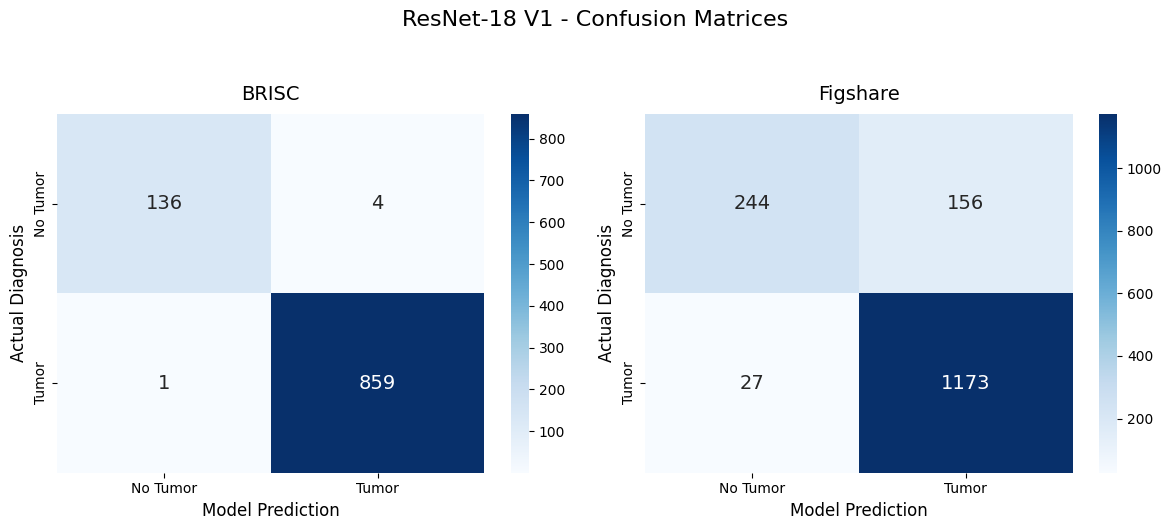

In [80]:
# --- Evaluate Model V1 ---
path_v1 = '/content/drive/MyDrive/my_models/my_brisc_binary_model.pth'
model_v1 = load_resnet_model(path_v1, device)

metrics_v1 = evaluate_model_multidataset(model_v1, test_loaders, device, THRESHOLD, "ResNet-18 V1")


Evaluating ResNet-18 V2 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    98.40% | Sensitivity: 99.88%
Specificity: 89.29% | F1-Score:    0.9908 | AUC: 0.9991

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    85.25% | Sensitivity: 99.42%
Specificity: 42.75% | F1-Score:    0.9100 | AUC: 0.9699


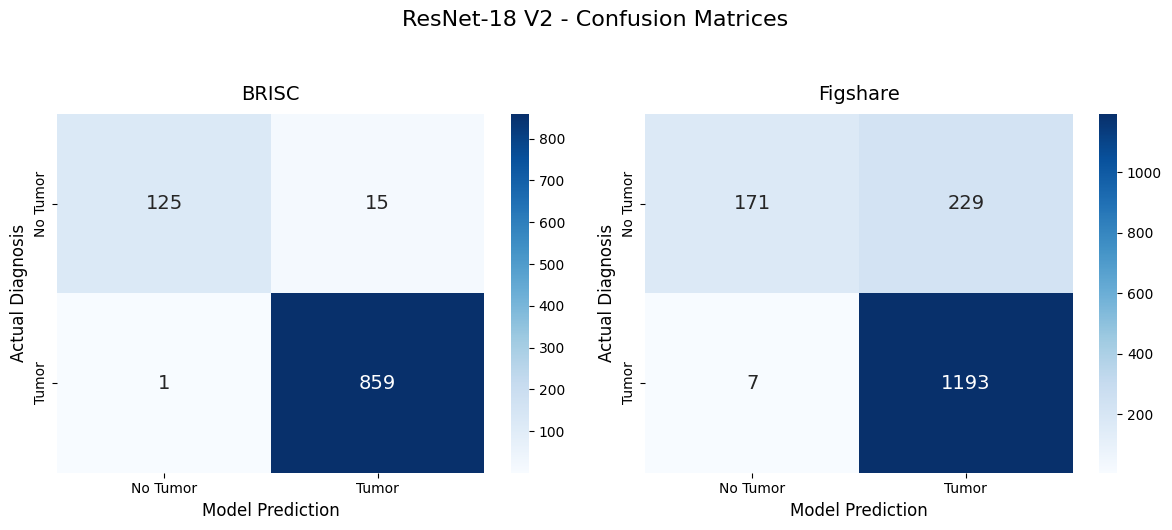

In [81]:
# --- Evaluate Model V2 ---
path_v2 = '/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model_312.pth'
model_v2 = load_resnet_model(path_v2, device)

metrics_v2 = evaluate_model_multidataset(model_v2, test_loaders, device, THRESHOLD, "ResNet-18 V2")


Evaluating ResNet-18 V3 on multiple datasets...

Processing BRISC Dataset...
--- BRISC Results ---
Accuracy:    95.10% | Sensitivity: 100.00%
Specificity: 65.00% | F1-Score:    0.9723 | AUC: 0.9997

Processing Figshare Dataset...
--- Figshare Results ---
Accuracy:    82.69% | Sensitivity: 99.92%
Specificity: 31.00% | F1-Score:    0.8964 | AUC: 0.9404


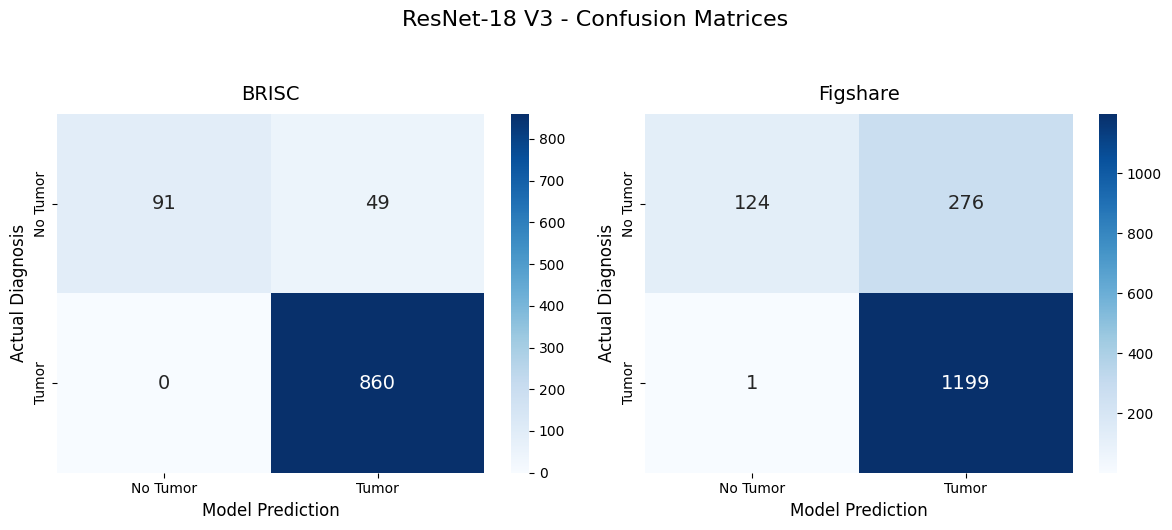

In [82]:
# --- Evaluate Model V3 ---
path_v3 = '/content/drive/MyDrive/my_models/Copy of my_brisc_binary_model.pth'
model_v3 = load_resnet_model(path_v3, device)

metrics_v3 = evaluate_model_multidataset(model_v3, test_loaders, device, THRESHOLD, "ResNet-18 V3")

In [76]:
import pandas as pd

# Combine the metric dictionaries into a single dictionary of dictionaries
all_metrics = {
    "ResNet-18 V1": metrics_v1,
    "ResNet-18 V2": metrics_v2,
    "ResNet-18 V3": metrics_v3
}

# Convert to a pandas DataFrame
df_comparison = pd.DataFrame(all_metrics)

# Optional: Format the numbers so they are easier to read (percentages for accuracy/sensitivity/specificity)
# We will leave F1 and AUC as standard decimals
def format_metrics(x, metric_name):
    if metric_name in ['Accuracy', 'Sensitivity', 'Specificity']:
        return f"{x * 100:.2f}%"
    return f"{x:.4f}"

for row in df_comparison.index:
    df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))

# Display the final table
print("\n=== Final Model Comparison ===")
display(df_comparison)


=== Final Model Comparison ===


/tmp/ipython-input-3675545937.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.20%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))
/tmp/ipython-input-3675545937.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '98.50%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_comparison.loc[row].apply(lambda x: format_metrics(x, row))
/tmp/ipython-input-3675545937.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '95.20%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comparison.loc[row] = df_c

,ResNet-18 V1,ResNet-18 V2,ResNet-18 V3
Accuracy,99.20%,98.50%,95.20%
Sensitivity,99.65%,99.88%,100.00%
Specificity,96.43%,90.00%,65.71%
F1,0.9954,0.9913,0.9729
AUC,0.9988,0.9993,0.9999
